This notebook is my attempt at *separating* out bat calls even when they are overlapping in time. Because we can see them as separate objects, my argument is that it should be possible to train a neural network to tell them apart. To enhance the 'separation' of the calls, I'm going to try to perform some basic image analysis options on the spectrograms, which will then be the features that the neural network will accept as input. 

I'm also hoping that the same image analysis methods will be able to rid the spectrograms of reverberations. 

In [1]:
from make_training_data import mean_subtract_rowwise,rms
import cv2
import numpy as np
from skimage.filters  import sobel
from skimage import measure
from skimage.morphology import skeletonize, convex_hull_image
from skimage.filters import threshold_otsu, threshold_local
from skimage import feature
import scipy.signal as signal 
import scipy.io.wavfile as wav
import scipy.stats as stats
import matplotlib.pyplot as plt
plt.rcParams['agg.path.chunksize'] = 10000


In [2]:
%matplotlib notebook

In [3]:
fs, audio = wav.read('wavs//'+'ch0_2018-07-28_22-06-13_1532804773.wav')

/home/tbeleyur/anaconda2/envs/deeplearning/lib/python2.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [4]:
calc_ind = lambda X : int(X*192000)

In [5]:
start, stop = 1.68, 1.72
start_ind, stop_ind = calc_ind(start), calc_ind(stop)

audio_segment = audio[start_ind:stop_ind]

In [6]:
f, t, S = signal.spectrogram(audio_segment, fs, nperseg=64, noverlap=0)
S = np.flipud(S)
mean_S = mean_subtract_rowwise(S)
if sum(mean_S.flatten()<=0.0) > 0 :
    mean_S += -np.min(mean_S) + 10.0**-5

In [7]:
log_meanS = 20*np.log10(mean_S)
log_S = np.copy(S)
if sum(S.flatten()<=0.0) > 0 :
    log_S += -np.min(mean_S) + 10.0**-5
    log_S = 20*np.log10(S)
else:
    log_S = 20*np.log10(S)

<IPython.core.display.Javascript object>


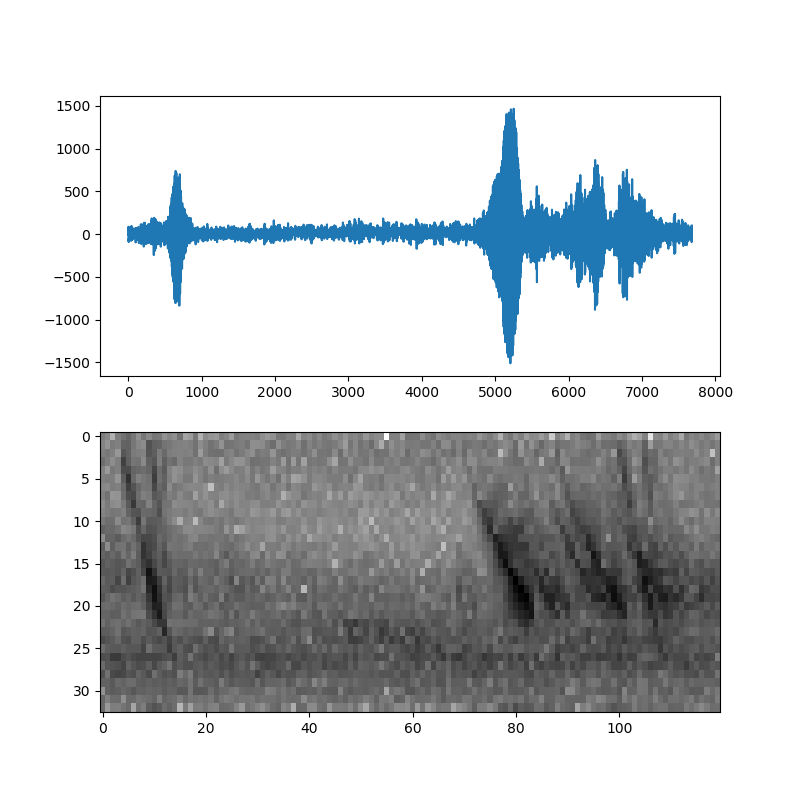

In [8]:
plt.figure(figsize=(8,8))
plt.subplot(211)
plt.plot(audio_segment)
plt.subplot(212)
plt.imshow(log_S, aspect='auto', cmap='Greys')

<IPython.core.display.Javascript object>


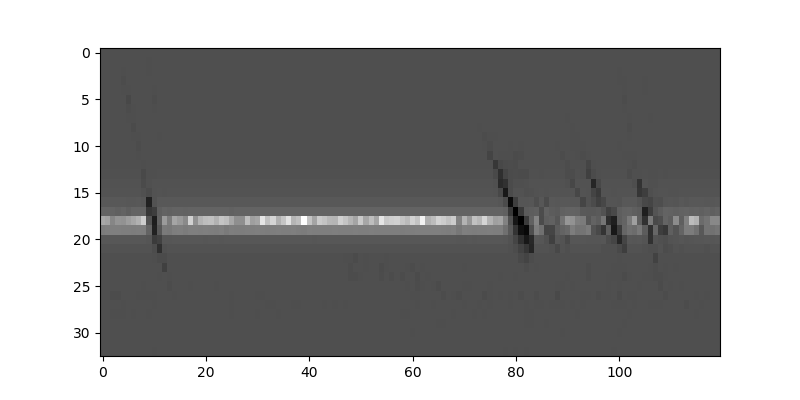

In [9]:
plt.figure(figsize=(8,4))
plt.imshow(log_meanS, aspect='auto', cmap='Greys')

Now, we see some kind of reverberation in the 300th FFt window. I'm going to try and see if doing some edge detection allows me to get rid of this reverberation.

In [10]:
threshold = np.percentile(log_meanS.flatten(),90)
S_sob = np.copy(log_meanS)
S_sob[S_sob<threshold] = -1 
S_sob[S_sob>threshold] = 1 
S_sob = np.uint8(S_sob)

In [11]:
# convert the image to 8bit first : 
S_8bit = np.copy(S)
S_8bit *= 1.0/np.max(S)
S_8bit *= 2**8 -1
S_8bit = np.uint8(S_8bit)
# threshold it 
ret,thresh = cv2.threshold(S_8bit,np.percentile(S_8bit.flatten(), 1),255,1)

otsu_thresh = threshold_otsu(S_8bit)
S_8bit_otsu = np.zeros(S_8bit.shape)
S_8bit_otsu[S_8bit>otsu_thresh] = 1 

block_size = 25
binary_adaptive = threshold_local(S_8bit, block_size)
S_8bit_adap = np.zeros(S_8bit.shape)
S_8bit_adap [ S_8bit > binary_adaptive] = 1 

<IPython.core.display.Javascript object>


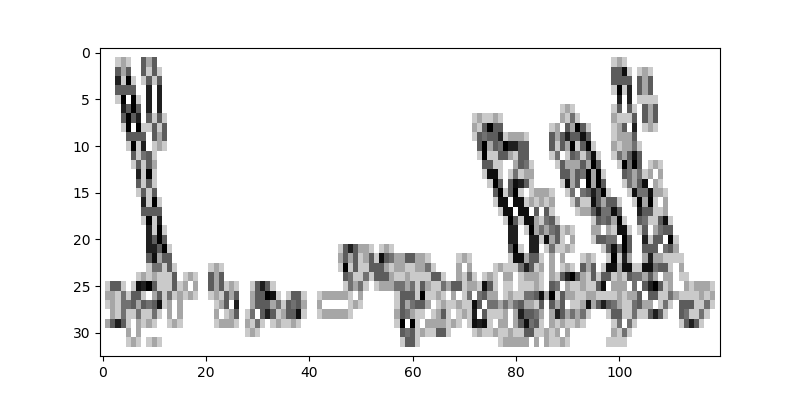

In [12]:
sobel_filtd = sobel(S_sob)
plt.figure(figsize=(8,4))
plt.imshow(sobel_filtd, aspect='auto', cmap='Greys')

Sobel filtering doesn't seem to work too well...

In [13]:
skeleton = skeletonize(S_8bit_adap)

<IPython.core.display.Javascript object>


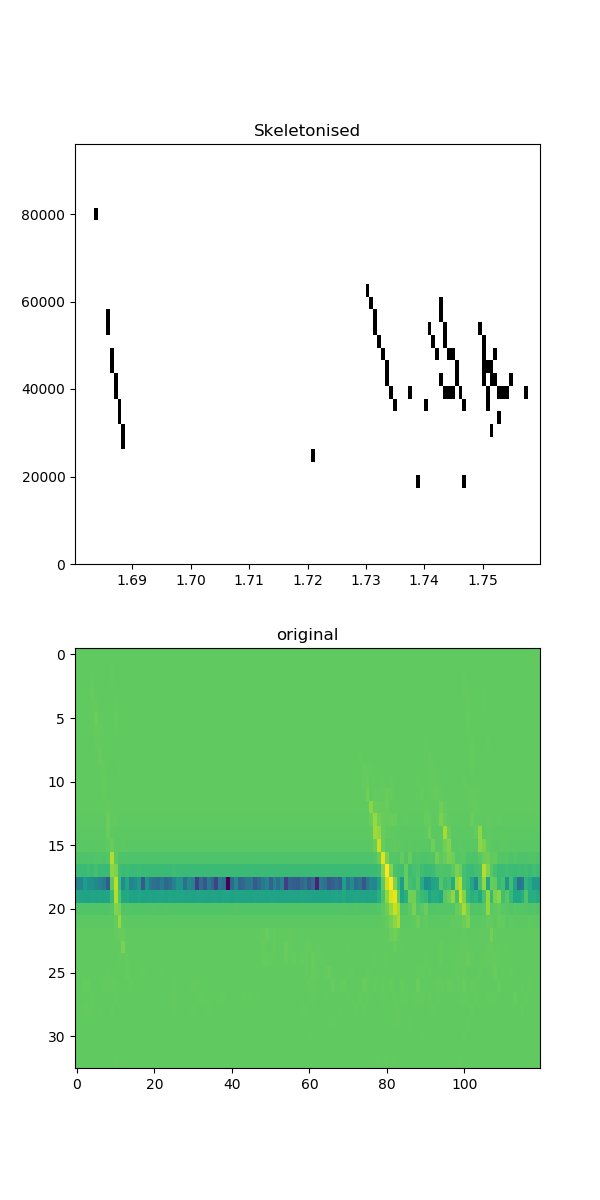

Text(0.5,1,'original')

In [14]:
plt.figure(figsize=(6,12))
plt.subplot(211)
plt.imshow(skeleton, aspect='auto', cmap='Greys', extent=[t[0]+start, t[-1]+stop, f[0], f[-1]])
plt.title('Skeletonised')
plt.subplot(212)
plt.imshow(log_meanS,  aspect='auto')
plt.title('original')

Skeletonisation too -- seems to do an *okay* job...

Let's now try canny edge detection : 

In [15]:
canny_filt = feature.canny(log_S, sigma=1)

<IPython.core.display.Javascript object>


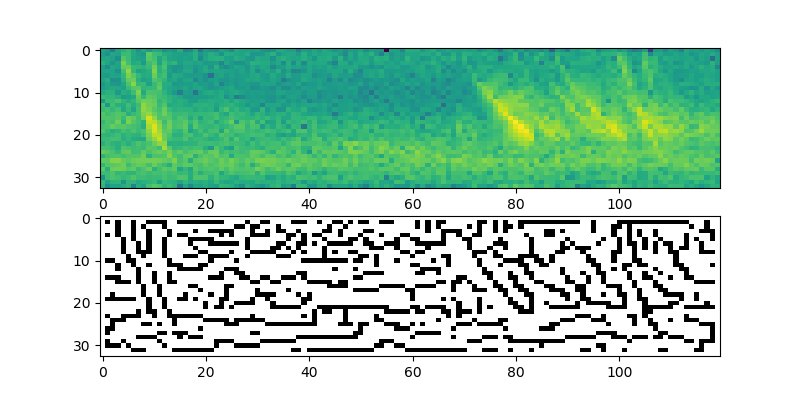

In [16]:

plt.figure(figsize=(8,4))
a = plt.subplot(211)
plt.imshow(log_S,  aspect='auto')
plt.subplot(212, sharex=a)
plt.imshow(canny_filt, aspect='auto', cmap='Greys')

Finally, let's try out contour detection as this might help to isolate the bat calls:

<IPython.core.display.Javascript object>


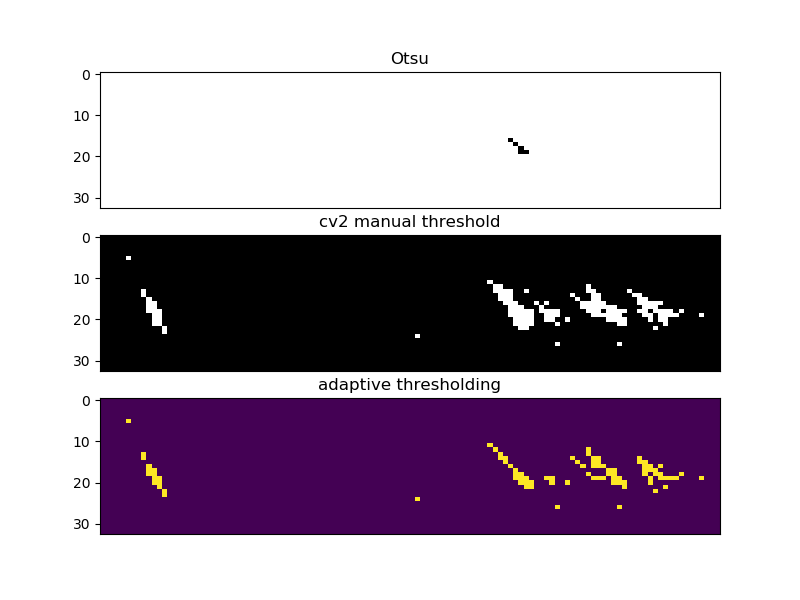

([], <a list of 0 Text xticklabel objects>)

In [17]:
plt.figure(figsize=(8,6))
plt.subplot(311)
plt.title('Otsu')
plt.imshow(S_8bit_otsu, aspect='auto', cmap='Greys')
plt.xticks([])
plt.subplot(312)
plt.imshow(thresh, aspect='auto', cmap='Greys')
plt.title('cv2 manual threshold')
plt.xticks([])
plt.subplot(313)
plt.title('adaptive thresholding')
plt.imshow(S_8bit_adap, aspect='auto')
plt.xticks([])



In [18]:
contours = measure.find_contours(S_8bit_adap, 0, fully_connected='high')

<IPython.core.display.Javascript object>


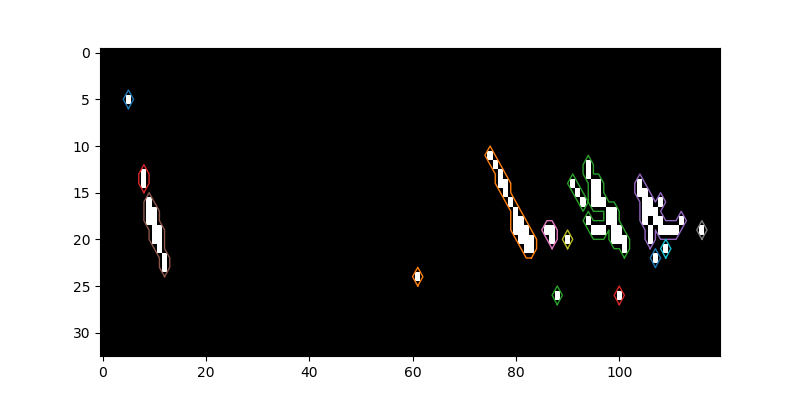

In [19]:
# Display the image and plot all contours found
plt.figure(figsize=(8,4))
plt.imshow(S_8bit_adap, aspect='auto', interpolation='nearest', cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=1)
plt.show()

Contour finding works pretty well - though it could get a bit messy when the 

Let's now combine the skeleton with the contours...and see what happens ...:


<IPython.core.display.Javascript object>


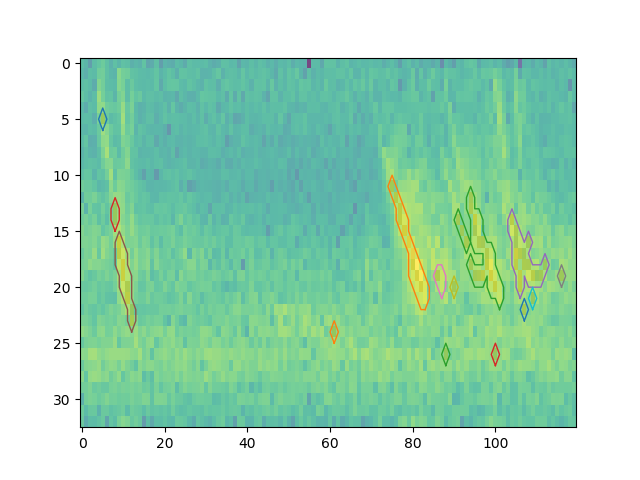

In [20]:
plt.figure()
for n, contour in enumerate(contours):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=1)
plt.imshow(log_S, aspect='auto', alpha=0.8)
plt.imshow(skeleton, aspect='auto', alpha=0.1, cmap='Greys')

So, here is the contour of the calls + the skeleton (not so visible, as they're dark yellow inside the contours). The idea is essentially to 
now use the two output methods to reliably extract the bat calls. 

*ONE problem with using local thresholding* : if I apply the same method for a long recording, faint calls will be ignored when there are loud calls, and faint calls will be detected in the presence of loud calls! 

In [21]:
[ cv2.contourArea(np.float32(contour)) for contour in contours]

[2.0, 29.5, 45.5, 4.0, 32.5, 20.0, 5.5, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]

In [22]:
# let's extract out that particular part of the call : 
i = 1

min_max_y = np.arange(np.min(contours[i][:,0]), np.max(contours[i][:,0]) +1)
min_max_x = np.arange(np.min(contours[i][:,1]), np.max(contours[i][:,1])+1)

min_max_x = np.int16(min_max_x)
min_max_y = np.int16(min_max_y)


section = log_S[:, min_max_x] 

In [23]:
min_max_x

array([74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84], dtype=int16)

<IPython.core.display.Javascript object>


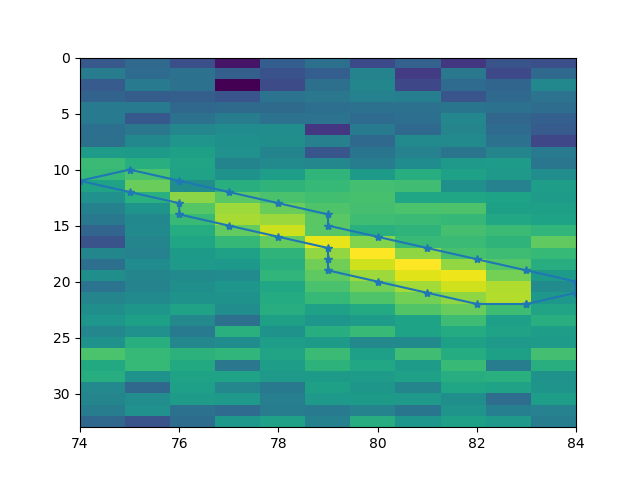

In [24]:
plt.figure()
plt.imshow(section, aspect='auto', extent=[min_max_x[0],min_max_x[-1], 33,0])
plt.plot(contours[i][:,1],contours[i][:,0],'*-')

In [25]:
np.min(contours[0][:,0]), np.max(contours[0][:,0])

(4.0, 6.0)

In [26]:
k = [np.random.normal(0,1,10), np.random.normal(0,1,10), np.random.normal(0,1,10)]
k_concat = np.concatenate(k)

In [27]:
k_rms = [rms(each) for each in k]
kconc_rms = rms(k_concat)
k_rms, kconc_rms

([0.8186697266043277, 0.7945092052070949, 1.0537897466189399],
 0.8966489146625197)

In [28]:
np.sqrt(np.mean((kconc_rms**2)))

0.8966489146625197